The goal of this notebook is to calculate correlations between all OTUs and each metadata variables, and look at the resulting p-value distributions.

We'll also explore whether ubiquity/prevalence seems like an informative covariate.

**IMPORTANT NOTE**: These correlation p-values don't seem to match the ones given by R. Not sure why this would be but I trust R more than scipy so don't want to dig into this too much...

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import spearmanr, kendalltau

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read in data
meta = pd.read_csv('DATA/enigma/metadata.txt', sep='\t', index_col=0)
df = pd.read_csv('DATA/enigma/otu_table_resampled_updated_r.txt', sep='\t', index_col=0)

# Subset the metadata with just the samples we want
meta['filter'] = [i.rsplit('_',1)[1] for i in meta.index]
meta = meta.query('filter == "02"')

# Make the metadata ID match what's in the OTU table
meta['otu_table_sample'] = ['.'.join(i.rsplit('_', 1)[0].split('_')) for i in meta.index]

# Compare samples
osamples = df.columns.tolist()
msamples = meta['otu_table_sample'].tolist()

bothsamples = [i for i in msamples if i in osamples]
len(bothsamples)

67

In [3]:
# Subsample both tables
# Also transpose OTU table so OTUs are in columns (makes things faster)
df = df[bothsamples].T
meta.index = meta['otu_table_sample']
# And make sure rows in metadata are in same order as in otu table
meta = meta.loc[df.index]

print(df.shape, meta.shape)

((67, 18936), (67, 60))


In [4]:
# Remove any OTUs which are not present in any of these samples
df = df.loc[:, df.sum() > 0]
print(df.shape)

# And which have fewer than 10 reads
df = df.loc[:, df.sum() > 10]
print(df.shape)


# Convert to relative abundance
df = df.divide(df.sum(axis=1), axis=0)

(67, 16236)
(67, 4007)


# Spearman correlation

See notes below: I don't think this is getting correct pvalues, seems that ties are driving p values way down in very sparse OTUs.

In [5]:
# Define function that I can use with pandas map
def my_spearmanr(col1, col2):
    r, p = spearmanr(col1, col2, nan_policy='omit')
    return p

In [7]:
res_lst = []
for c in meta.columns:
    print(c)
    pvals = df.apply(lambda col: my_spearmanr(col, meta[c]))
    pvals = pvals.reset_index().rename(columns={0: 'pval'})
    pvals['metadata'] = c
    res_lst.append(pvals)
    
#c = 'pH'
#print(c)
#pvals = df.apply(lambda col: my_spearmanr(col, meta[c]))
#pvals = pvals.reset_index().rename(columns={0: 'pval'})
#pvals['metadata'] = c
#print(pvals.head())
#res_lst.append(pvals)


AODC_cellsmL
Ag_mgL
Al_mgL
As_mgL
Ba_mgL
Be_mgL
Bi_mgL
Boring_depth
Bot_depth
Bot_elevation
Br_mgL
CH4_mM
CO2_mM
Ca_mgL
Cd_mgL
Cl_mgL
Co_mgL
Concentration_nguL
Conductivity_Scm
Cr_mgL
Cs_mgL
Cu_mgL
DIC_mgL
DOC_mgL
DO_mgL
Depth
Elevation
Fe_mgL
Ga_mgL
Iron_mgL
K_mgL
Latitude
Li_mgL
Longitude
Mg_mgL
Mn_mgL
N2O_mM
N2_mM
NO3_mgL
Na_mgL
Ni_mgL
O2_mM
PO4_mgL
Pb_mgL
Redox_mV
SO4_mgL
Screen_height
Se_mgL
Sr_mgL
Sulfide_mgL
Temperature_C
Top_depth
Top_elevation
U_mgL
Zn_mgL
pH
I_all_mgL
S_all_mgL
filter


/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)
/Users/claire/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/claire/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/_distn

otu_table_sample


In [8]:
allres = pd.concat(res_lst)

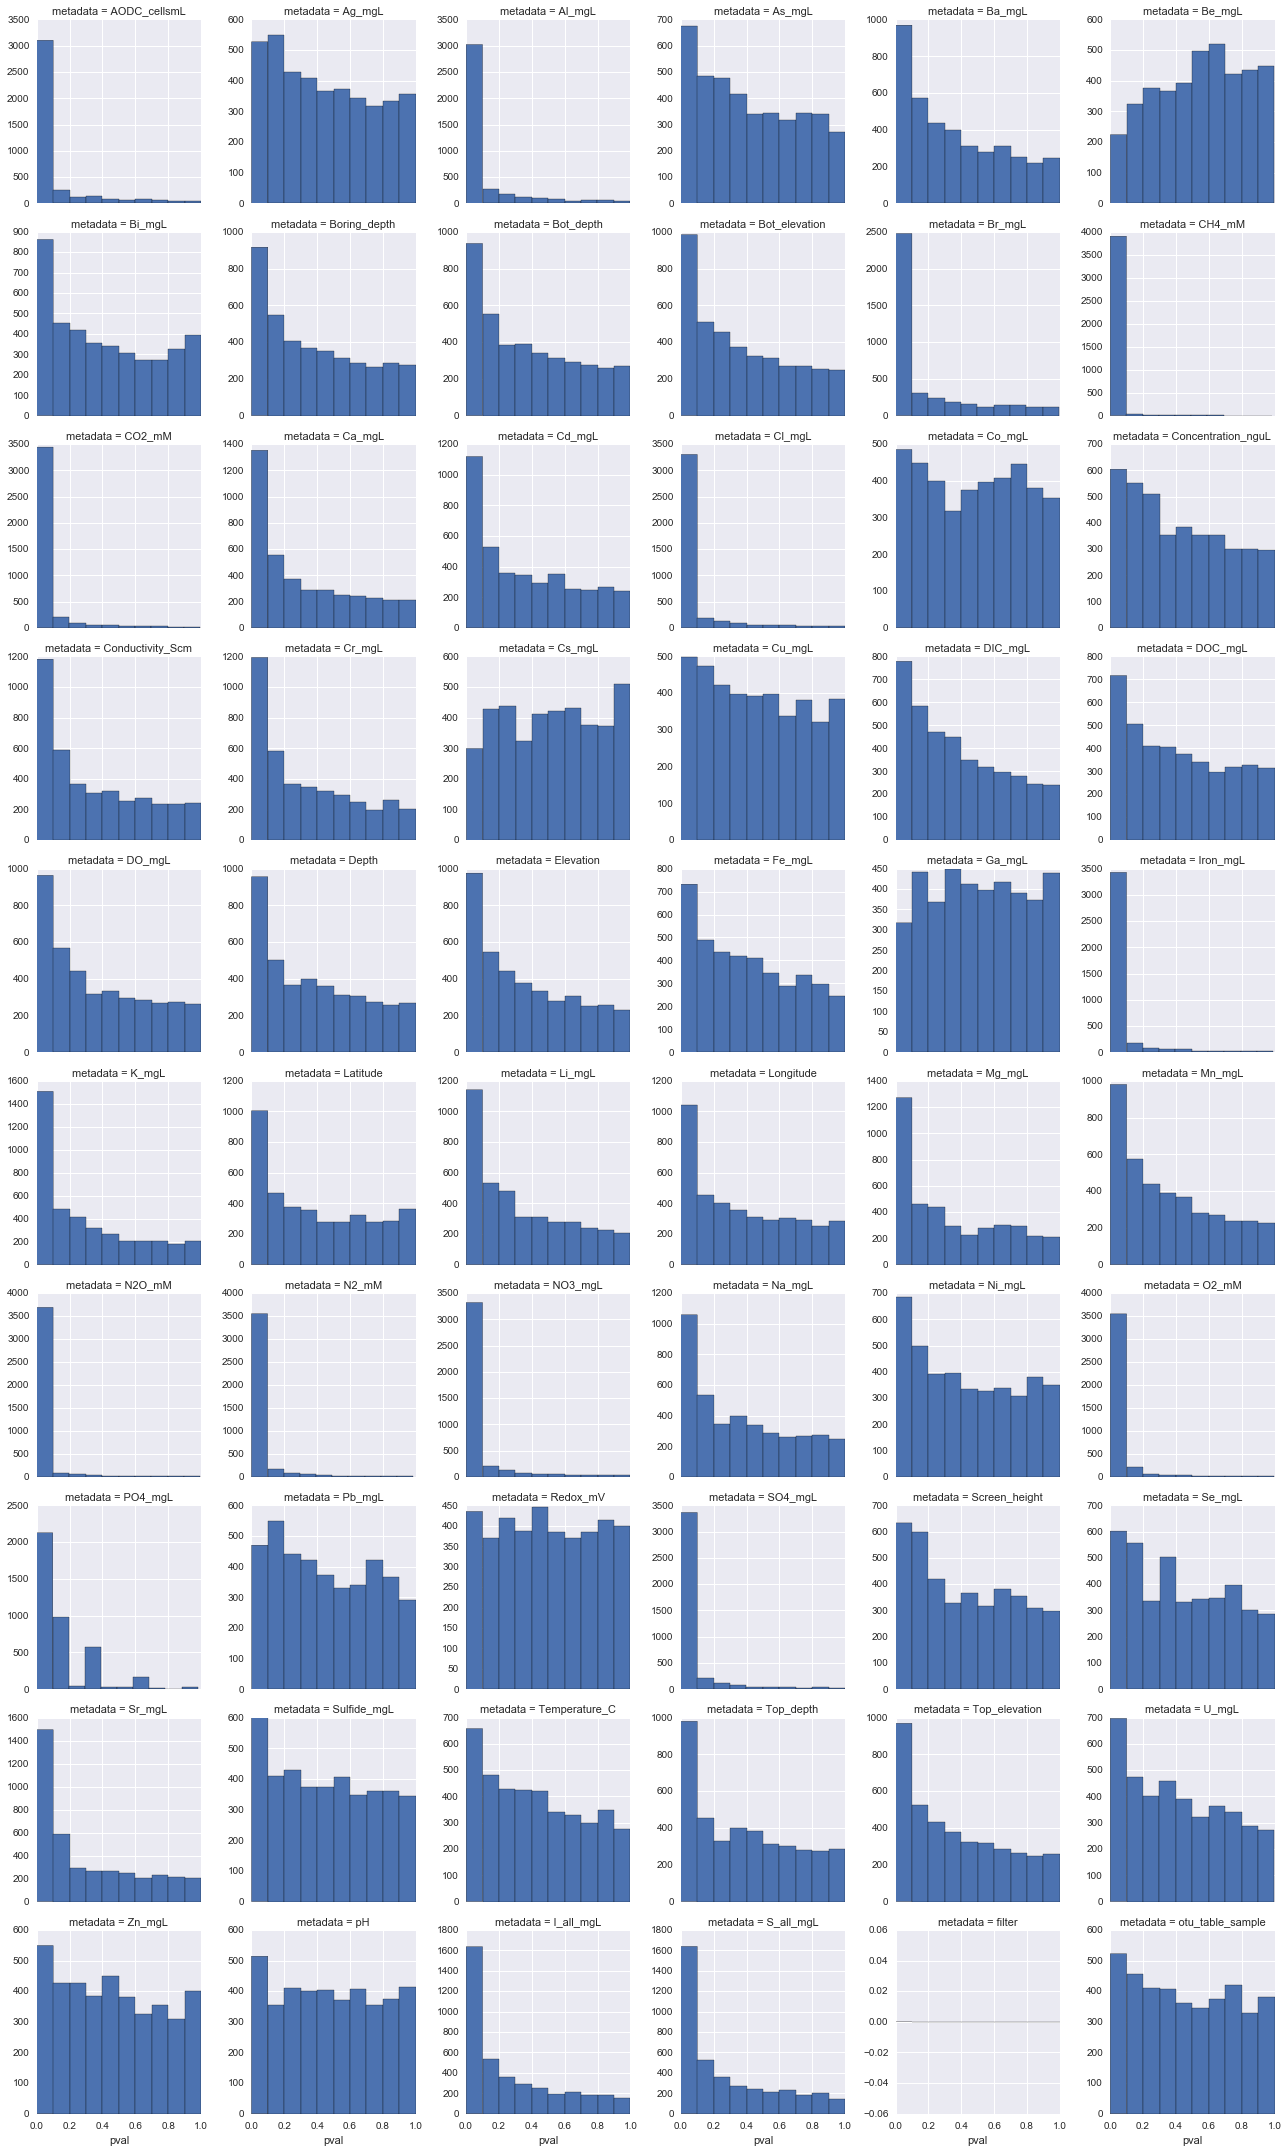

In [9]:
g = sns.FacetGrid(data=allres, col='metadata', sharey=False, col_wrap=6)
g.map(plt.hist, 'pval')

## Informative covariate?

In [10]:
ubi = (df > 0).sum() / df.shape[0]
ubi.name = 'ubiquity'

# Merge ubiquity with the pvalue results
allres = allres.join(ubi, on='OTU_ID')

In [11]:
allres['log_ubiquity'] = np.log10(allres['ubiquity'])
def unmask(x):
    try:
        return x.compressed()[0]
    except AttributeError:
        return x

allres['unmasked_pval'] = allres['pval'].apply(lambda x: unmask(x))
allres['log_pval'] = np.log10(allres['unmasked_pval'])

/Users/claire/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: divide by zero encountered in log10


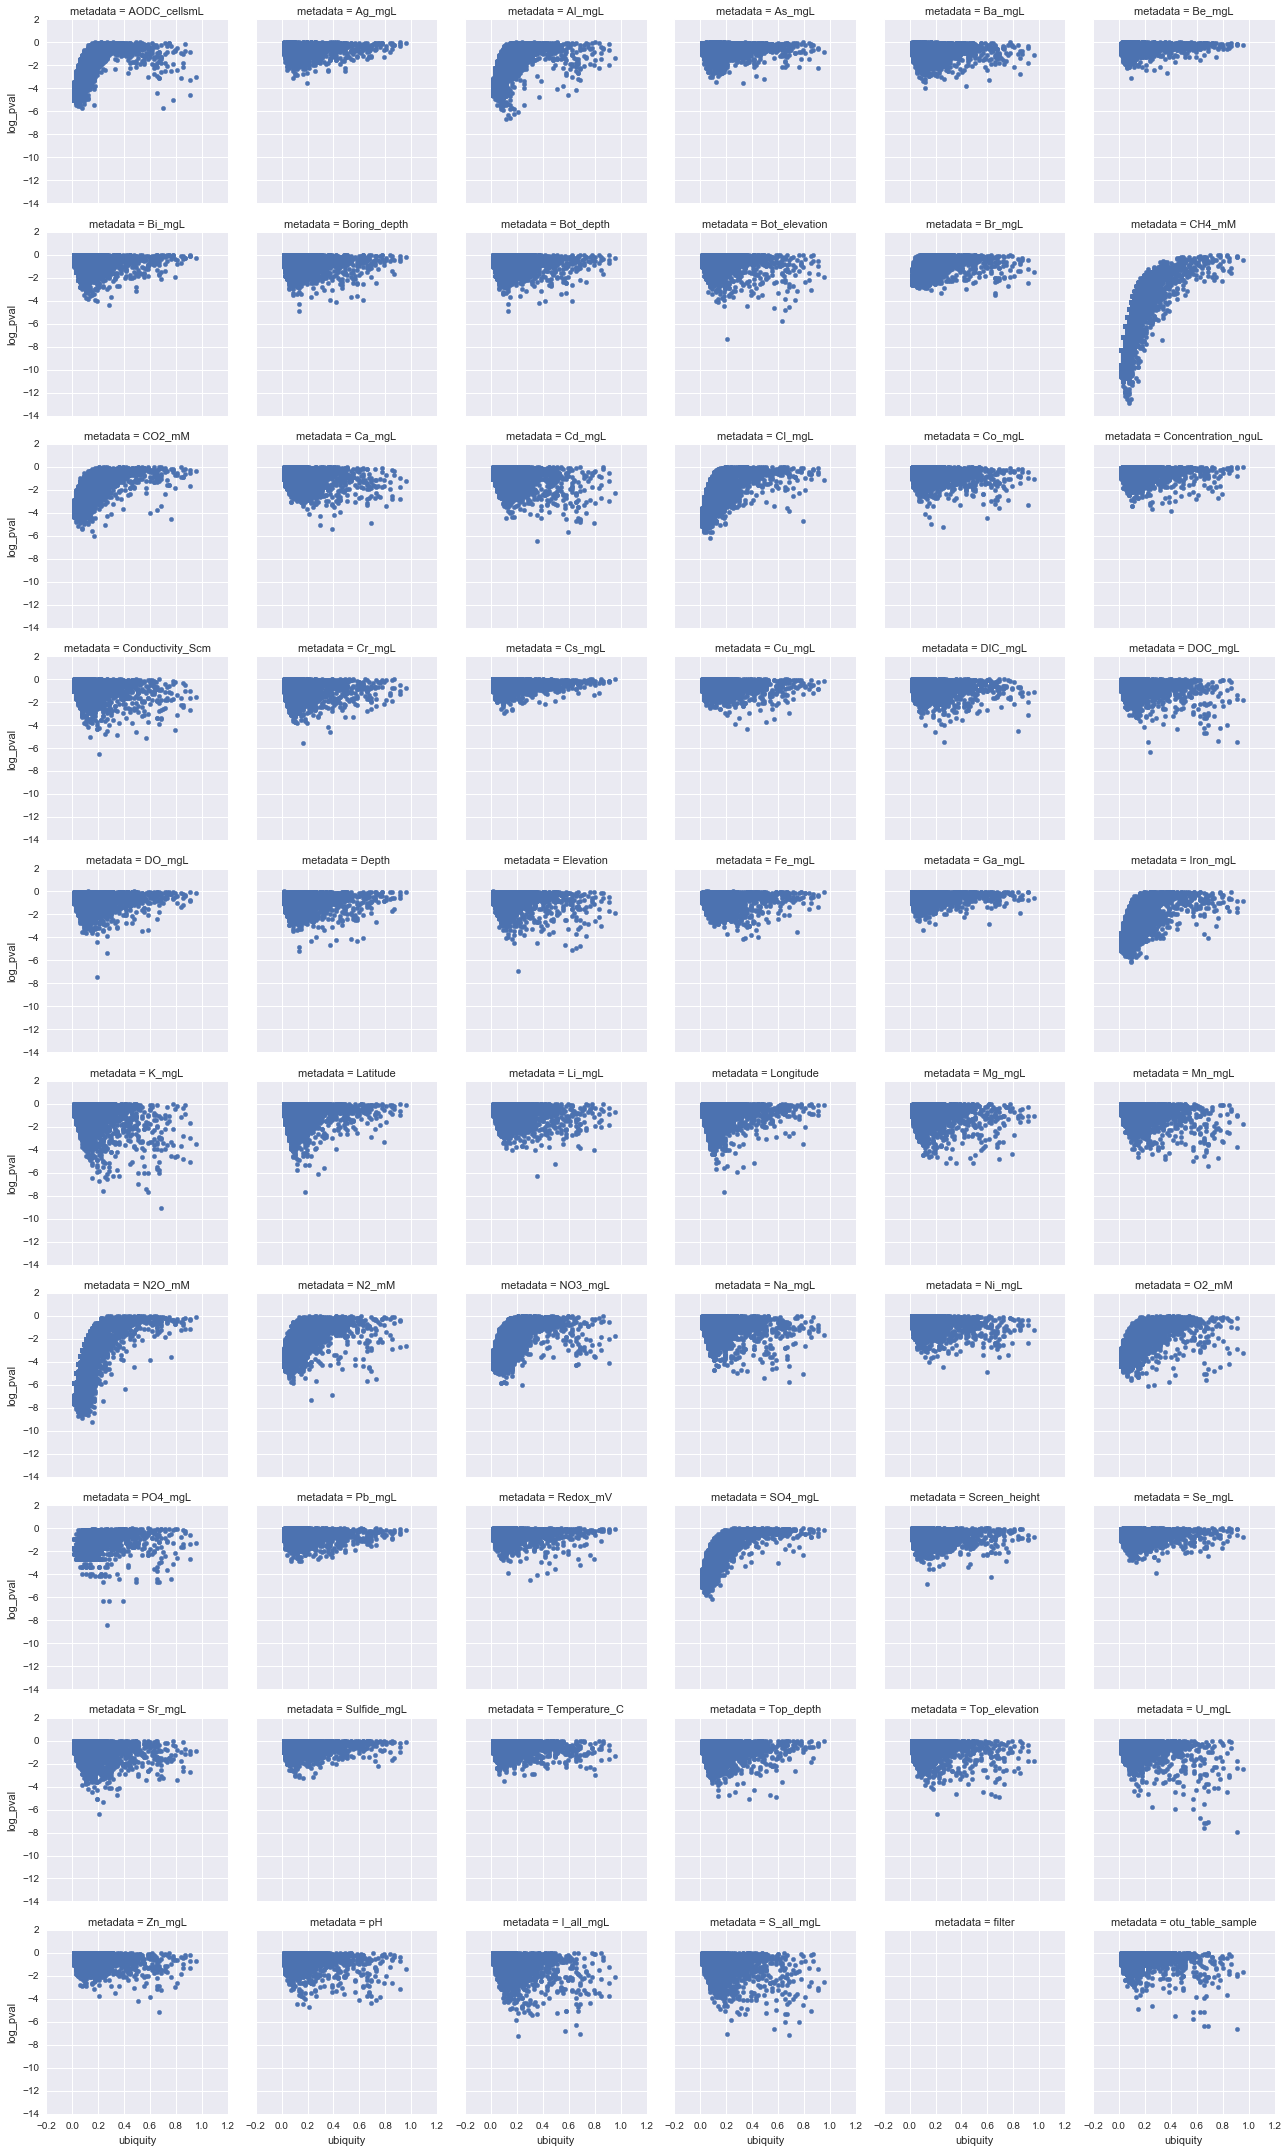

In [12]:
g = sns.FacetGrid(data=allres, col='metadata', col_wrap=6)
g.map(plt.scatter, 'ubiquity', 'log_pval')

Hm, strange that in this case, ubiquity seems informative but the other way - less ubiquitous things are more significant. Maybe rare bugs bloom in very high concentration of metals, but are usually not frequently present, or something like that? 

Anyway, moving forward let's (1) ask Eric what he thinks about these results but at the same time (2) do our benchmarking on `CH4_mM`, `pH`, and `Bi_mgL`. These seem to be varying levels of informativeness... 

In [36]:
allres.query('metadata == "SO4_mgL"').sort_values(by='pval').head()

,OTU_ID,pval,metadata,ubiquity,log_ubiquity,unmasked_pval,log_pval
3157,OTU14830,6.42641109647e-07,SO4_mgL,0.089552,-1.047924,6.426411e-07,-6.192031
3629,OTU7484,1.16993455337e-06,SO4_mgL,0.074627,-1.127105,1.169935e-06,-5.931838
2688,OTU1888,1.62174948598e-06,SO4_mgL,0.044776,-1.348954,1.621749e-06,-5.790016
719,OTU473,1.74269079348e-06,SO4_mgL,0.044776,-1.348954,1.742691e-06,-5.758780
2095,OTU2019,2.60804570274e-06,SO4_mgL,0.059701,-1.224015,2.608046e-06,-5.583685


(-0.0005, 0.001)

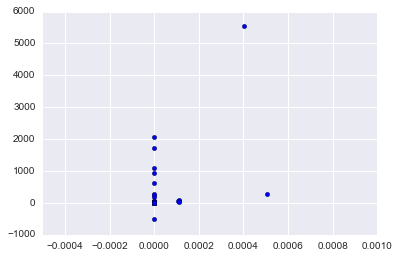

In [37]:
# This OTU has p = 1e-7... this is cleary wrong!
plt.scatter(df["OTU14830"].fillna(-0.5), meta["SO4_mgL"].fillna(-500))
plt.xlim(-0.0005, 0.001)

Just this one example convinces me that python is doing something wonky with ties - this OTU is mostly zero, with only a handful of non-zero points that drive the highly significant correlation.

Tie-handling also explains why less ubiquitous OTUs are more significant - it's because more sparse OTUs have more ties and are freaking out the significance!

I think I should try Kendall's rank correlation instead...

# Kendall tau correlation

In [5]:
# Define function that I can use with pandas map
def my_kendallt(col1, col2):
    r, p = kendalltau(col1, col2, nan_policy='omit')
    return p

In [6]:
res_lst = []
for c in meta.columns:
    print(c)
    pvals = df.apply(lambda col: my_kendallt(col, meta[c]))
    pvals = pvals.reset_index().rename(columns={0: 'pval'})
    pvals['metadata'] = c
    res_lst.append(pvals)
    
#c = 'pH'
#print(c)
#pvals = df.apply(lambda col: my_spearmanr(col, meta[c]))
#pvals = pvals.reset_index().rename(columns={0: 'pval'})
#pvals['metadata'] = c
#print(pvals.head())
#res_lst.append(pvals)


AODC_cellsmL


/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:554: RuntimeWarning: invalid value encountered in double_scalars
  tau = (C-D) / denom
/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:576: RuntimeWarning: invalid value encountered in double_scalars
  z = (C-D)/np.sqrt(var_s)


Ag_mgL
Al_mgL
As_mgL
Ba_mgL
Be_mgL
Bi_mgL
Boring_depth
Bot_depth
Bot_elevation
Br_mgL


/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/mstats_basic.py:576: RuntimeWarning: invalid value encountered in sqrt
  z = (C-D)/np.sqrt(var_s)


CH4_mM
CO2_mM
Ca_mgL
Cd_mgL
Cl_mgL
Co_mgL
Concentration_nguL
Conductivity_Scm
Cr_mgL
Cs_mgL
Cu_mgL
DIC_mgL
DOC_mgL
DO_mgL
Depth
Elevation
Fe_mgL
Ga_mgL
Iron_mgL
K_mgL
Latitude
Li_mgL
Longitude
Mg_mgL
Mn_mgL
N2O_mM
N2_mM
NO3_mgL
Na_mgL
Ni_mgL
O2_mM
PO4_mgL
Pb_mgL
Redox_mV
SO4_mgL
Screen_height
Se_mgL
Sr_mgL
Sulfide_mgL
Temperature_C
Top_depth
Top_elevation
U_mgL
Zn_mgL
pH
I_all_mgL
S_all_mgL
filter


/Users/claire/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


otu_table_sample


In [7]:
allres_kendall = pd.concat(res_lst)

In [11]:
allres_kendall.to_csv('RESULTS/enigma_kendall_tau_results.txt', sep='\t')

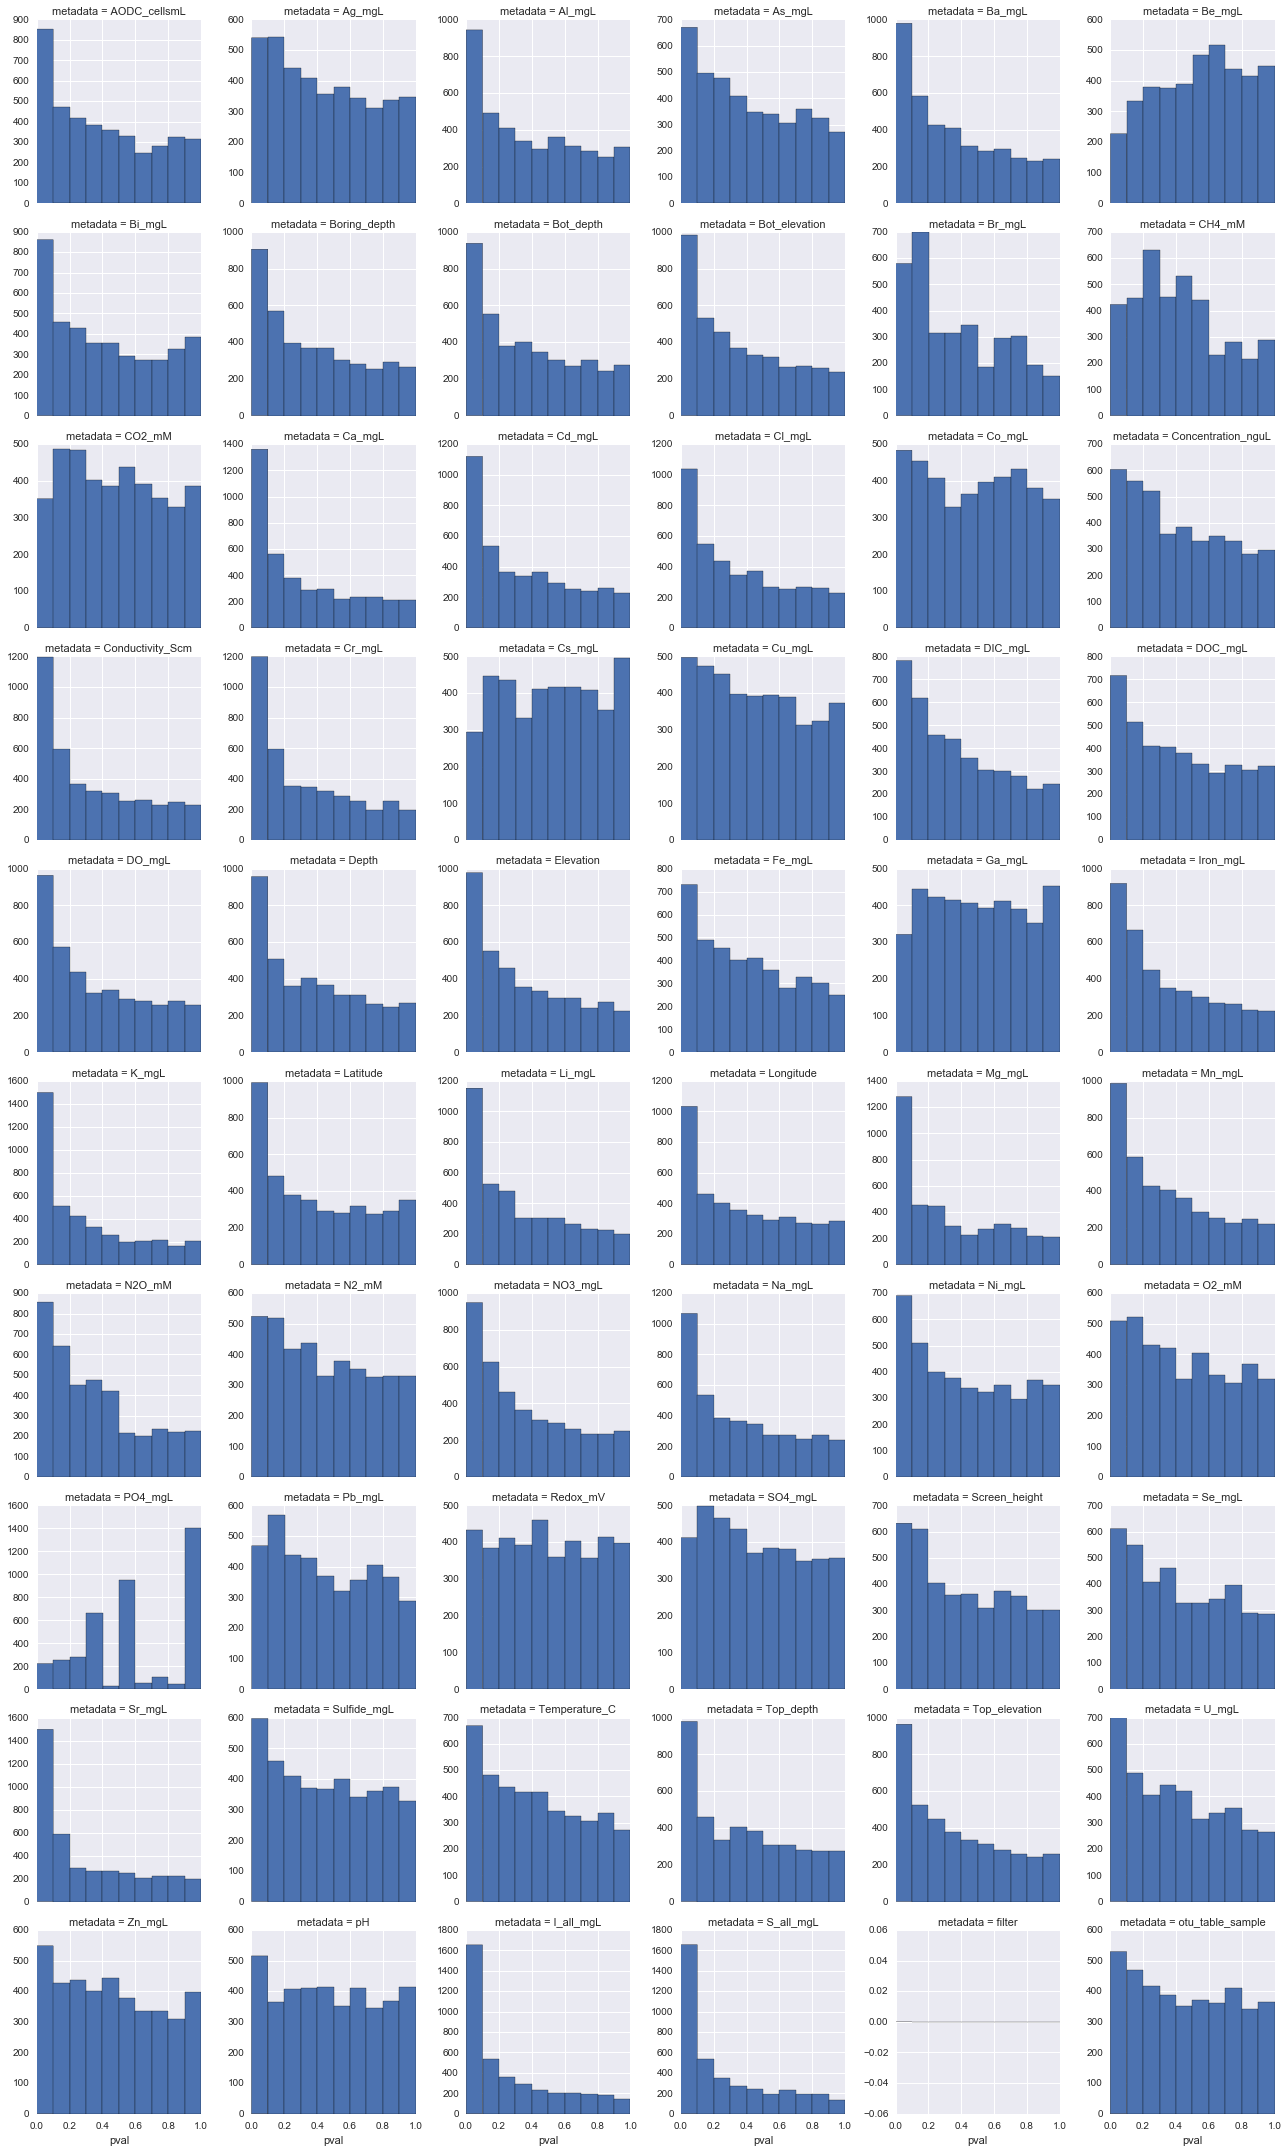

In [8]:
g = sns.FacetGrid(data=allres_kendall, col='metadata', sharey=False, col_wrap=6)
g.map(plt.hist, 'pval')

In [9]:
ubi = (df > 0).sum() / df.shape[0]
ubi.name = 'ubiquity'

# Merge ubiquity with the pvalue results
allres_kendall = allres_kendall.join(ubi, on='OTU_ID')

allres_kendall['log_ubiquity'] = np.log10(allres_kendall['ubiquity'])

def unmask(x):
    try:
        return x.compressed()[0]
    except AttributeError:
        return x

allres_kendall['unmasked_pval'] = allres_kendall['pval'].apply(lambda x: unmask(x))
allres_kendall['log_pval'] = np.log10(allres_kendall['unmasked_pval'])

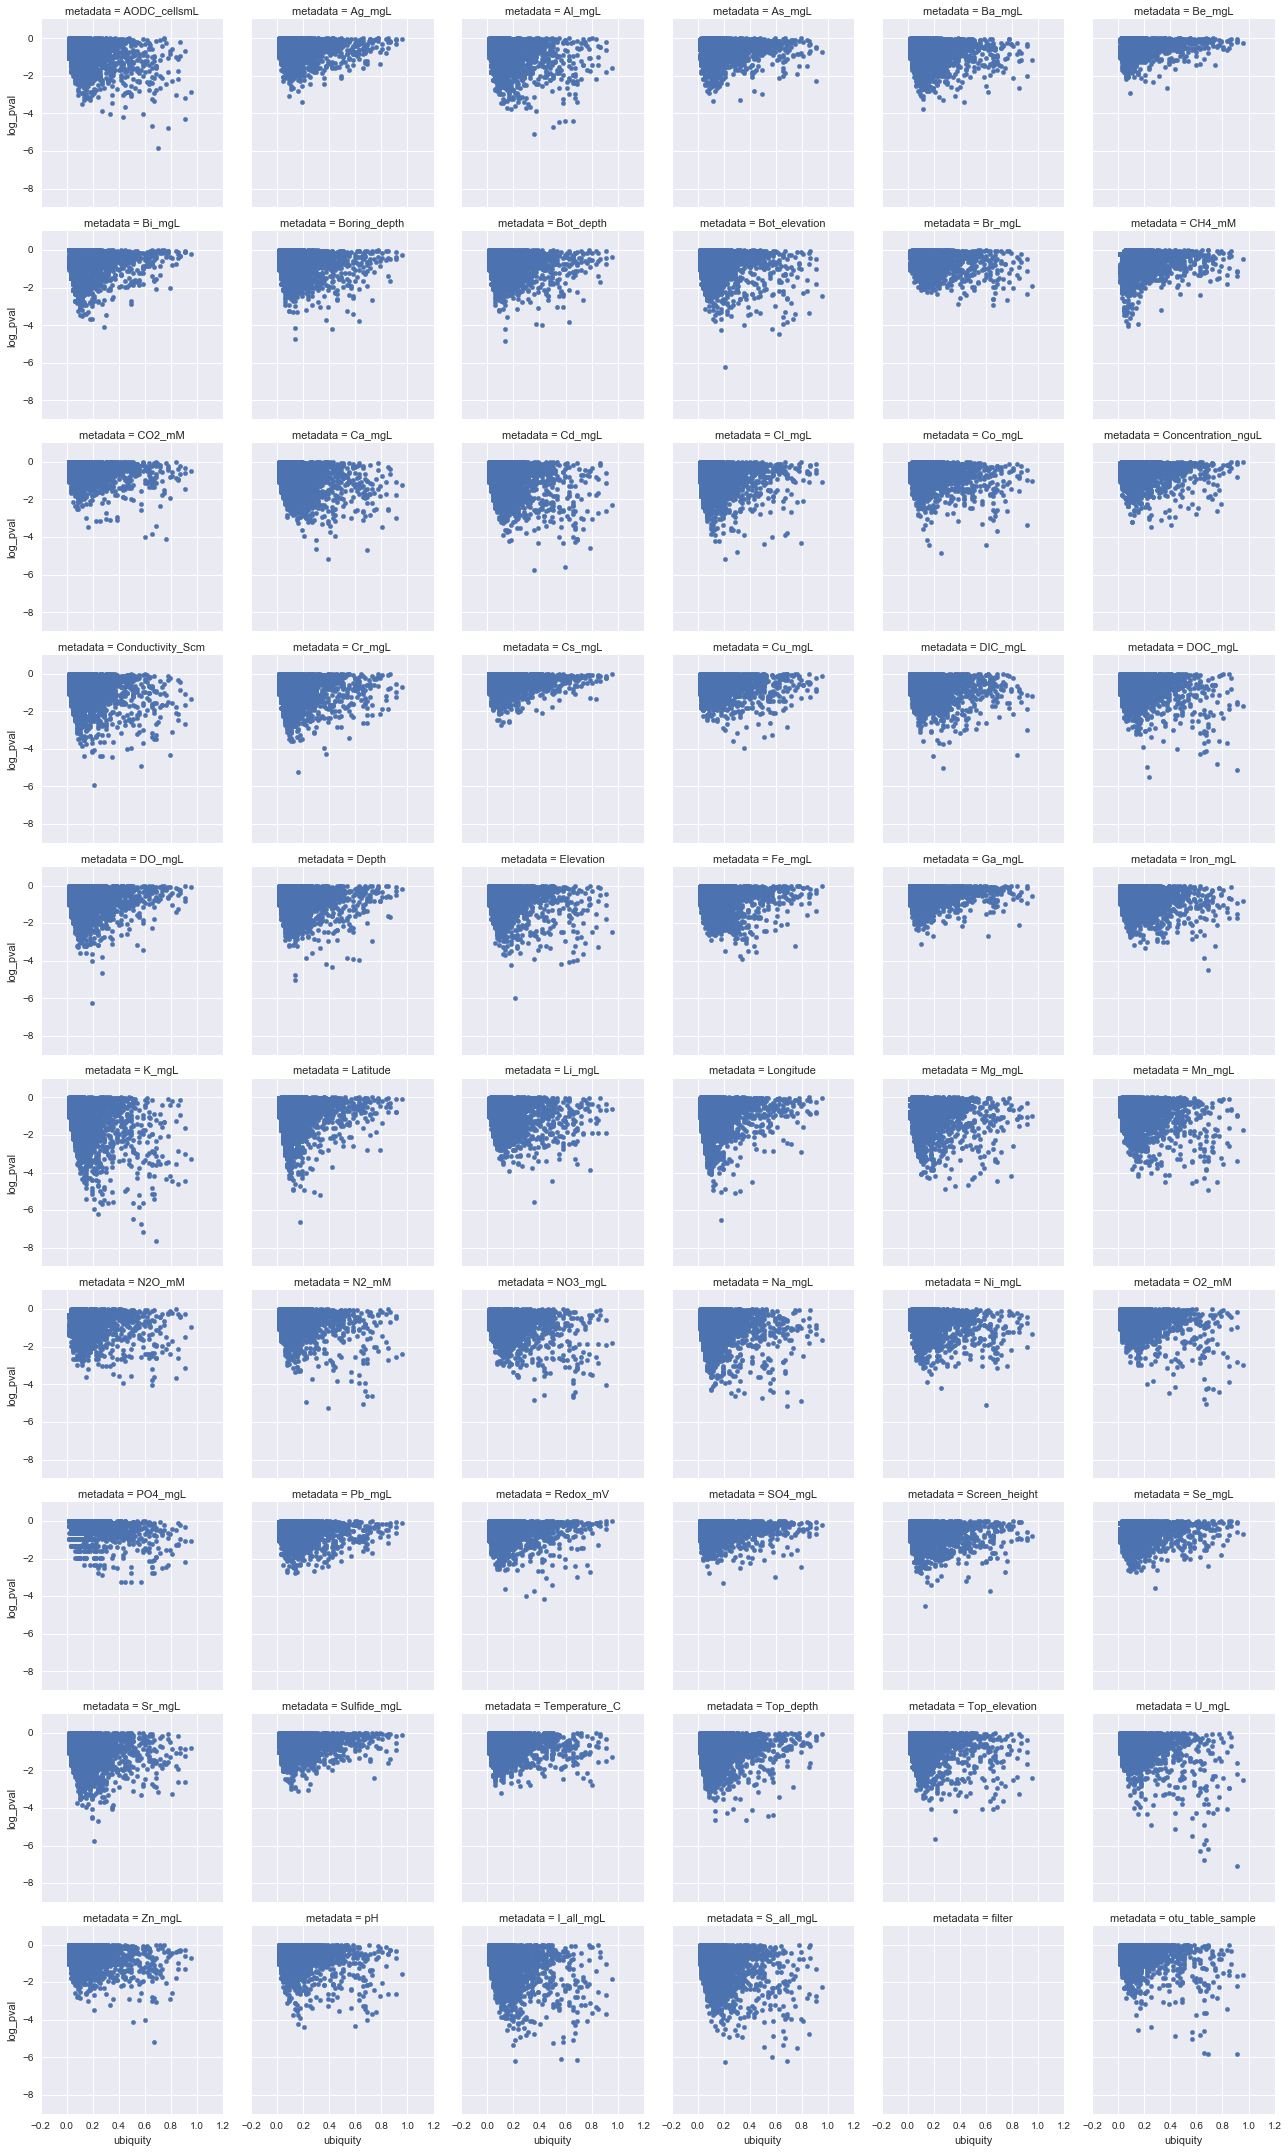

In [10]:
g = sns.FacetGrid(data=allres_kendall, col='metadata', col_wrap=6)
g.map(plt.scatter, 'ubiquity', 'log_pval')